In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *
from test_function import test
from NN_classes import *

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

cpu


index exceeds number of initial conditions -> random value chosen


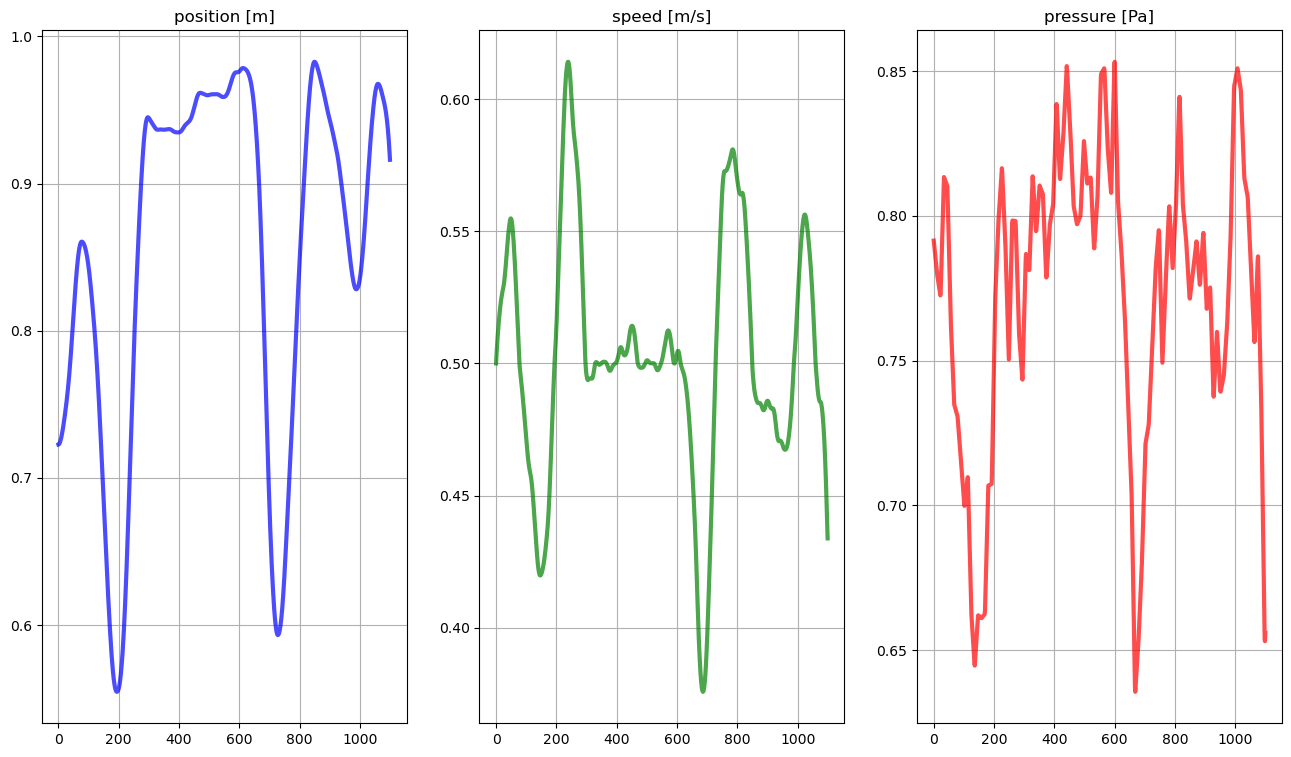

In [2]:
# Import the data generated via matlab/simulink:

data_tensor, PSW_max = get_data(path = r"data\save_data_test5.csv", timesteps_from_data=0, skip_steps_start = 0,
                                 skip_steps_end = 0, drop_half_timesteps = False, normalise_s_w="minmax", rescale_p=False, num_inits=0)

# View an example of a simulation run
visualise(data_tensor, num_inits=9000)

In [3]:
#with future:
def train(loader, model, weight_decay, learning_rate=0.001, ws=0, batch_size=1):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
 
    model.train()
    total_loss = []
  
    for k, (x, x_last, y) in enumerate(loader):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)
        x_last = x_last.to(device)
        x_last = x_last.squeeze()
       #print(x.size(), y.size(), x_last.size())
        
        output = model(x)
        pred = x_last[:,1:] + output

        #print(output.size())
        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(pred, y[:,1:])
        loss.backward()
        optimizer.step()
 
        total_loss.append(loss.detach().cpu().numpy())
 
   # return the average error of the next step prediction
    return np.mean(total_loss)

In [4]:

params =                 {
                           "experiment_number" : 2,
                           "window_size" : 16,
                           "h_size" : 48,
                           "l_num" : 3,
                           "epochs" : 100,
                           "learning_rate" : 0.001,
                           "part_of_data" : 50, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.8,
                           "batch_size" : 1000,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True,
                           "act_fn" : "relu",
                           "nonlin_at_out" : "tanh" #None if no nonlinearity at the end
                        }


# Initialize the LSTM model
model = MLP(input_size=3*params["window_size"], hidden_size = params["h_size"], l_num=params["l_num"], output_size=2, act_fn = params["act_fn"], act_at_end = params["nonlin_at_out"]).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1, PSW_max = get_data(path = "data\save_data_test5.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data\Testruns_from_trajectory_generator_200.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data = torch.cat((input_data1, input_data2))
input_data = input_data1
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set = CustomDataset_mlp(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"])#, pin_memory=True)

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(params["epochs"])):
    
    loss_epoch = train(train_loader, model, params["weight_decay"], learning_rate= params["learning_rate"], ws=params["window_size"], batch_size=params["batch_size"])
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%20 == 0:

        _,_, err_train = test(input_data, model, model_type = "mlp", window_size=params["window_size"], display_plots=False, num_of_inits = 20, set_rand_seed=True, physics_rescaling = PSW_max)

        average_traj_err_train.append(err_train)
        #average_traj_err_test.append(err_test)
        print(f"Epoch: {e}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
                #print(f"Average error over full trajectories: testing data : {err_test}")

_,_, err_train = test(input_data, model, model_type = "mlp", window_size=params["window_size"], display_plots=True, num_of_inits = 1, set_rand_seed=True, physics_rescaling = PSW_max)
#_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
print(f"TRAINING FINISHED: Average error over full trajectories: training data : {err_train}")
#print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

torch.Size([50, 550, 3])


  1%|          | 1/100 [00:05<08:24,  5.10s/it]


KeyboardInterrupt: 

torch.Size([50, 2750, 3])


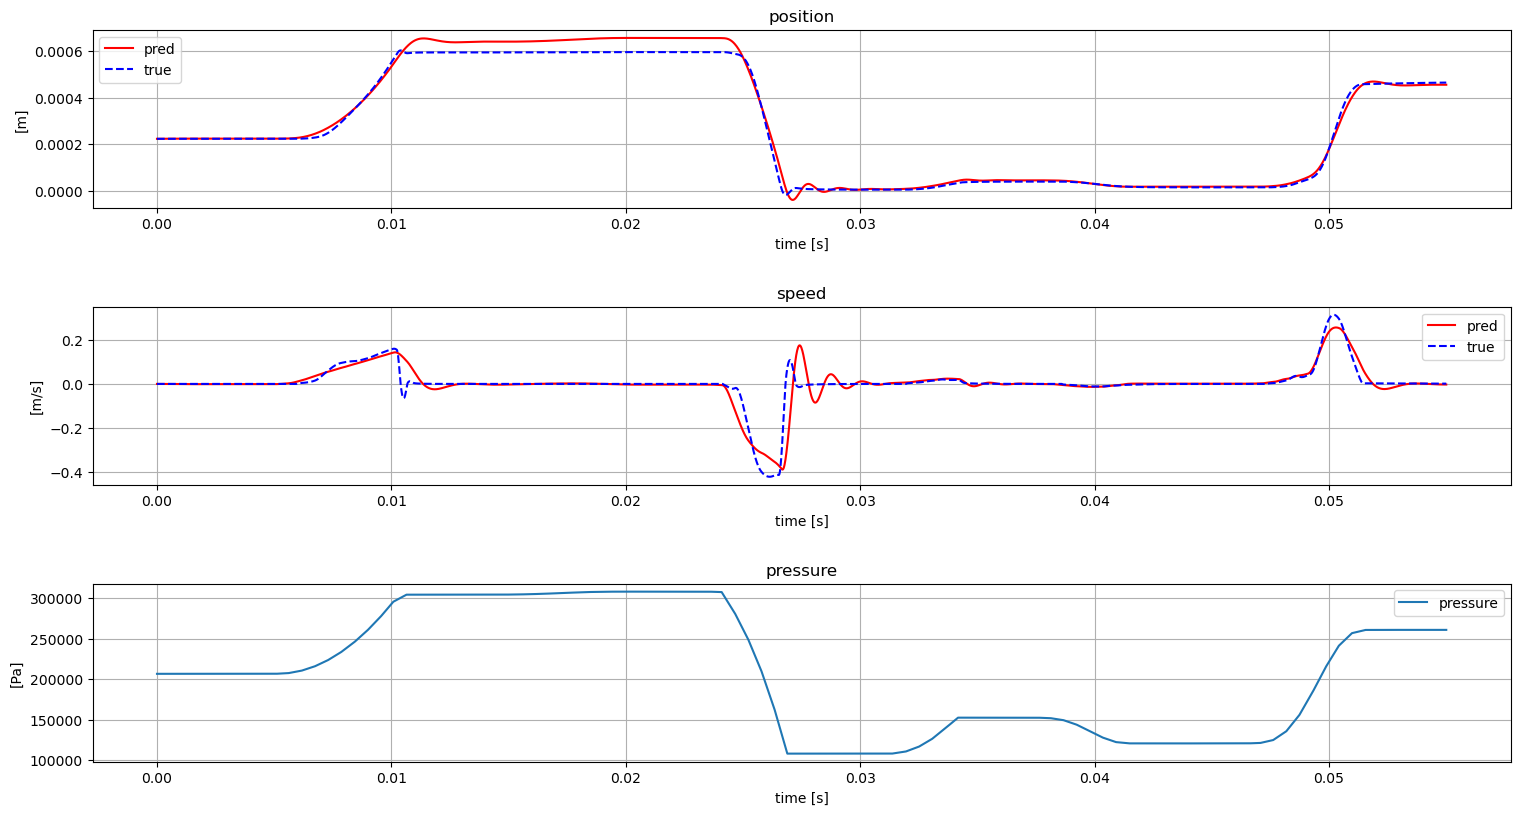

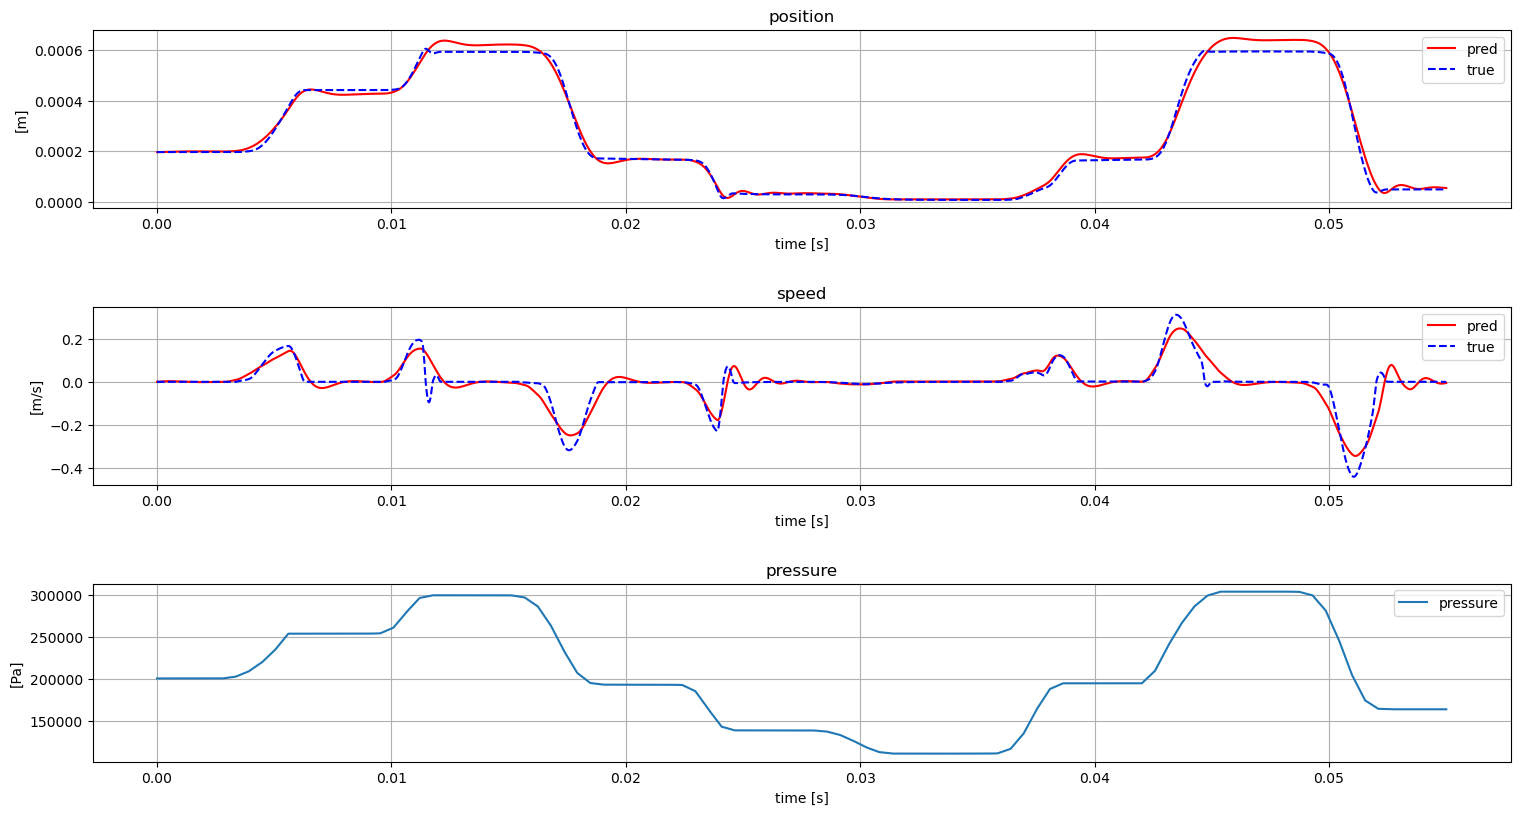

0.0018606298280223216


In [7]:
# Save the model
#path = f"Ventil_trained_NNs\lstm_ws0.pth"
#torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = "working_networks\MLP_5_8_1.pth"

params =                                                    {
                            "experiment_number" : 2,
                           "window_size" : 5,
                           "h_size" : 8,
                           "l_num" : 1,
                           "epochs" : 500,
                           "learning_rate" : 0.001,
                           "part_of_data" : 100, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.8,
                           "batch_size" : 200,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True,
                           "act_fn" : "relu",
                           "nonlin_at_out" : None #None if no nonlinearity at the end
                        }

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1, PSW_max = get_data(path = "data\save_data_test_5xlonger.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data\save_data_test_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

#input_data = torch.cat((input_data1, input_data2))
input_data = input_data1
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]
np.random.seed()

# dataloader for batching during training
train_set = CustomDataset_mlp(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"])#, pin_memory=True)


model = MLP(input_size=3*params["window_size"], hidden_size = params["h_size"], l_num=params["l_num"], output_size=2, act_fn = params["act_fn"], act_at_end = params["nonlin_at_out"]).to(device)
model.load_state_dict(torch.load(path, map_location=torch.device(device)))
                                 
train_data = input_data[train_inits,:,:]

#test_loss, test_loss_deriv, total_loss = test(test_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 8, test_inits=len(test_data), rand=False, PSW_max=PSW_max)

test_loss, test_loss_deriv, total_loss = test(test_data.to(device), model, model_type = "mlp", window_size=params["window_size"], display_plots=True, num_of_inits = 2, set_rand_seed=False, physics_rescaling = PSW_max)
print(total_loss)

In [ ]:
input_data.get_device()

torch.Size([1, 550, 3])
anzahl der variablen 146


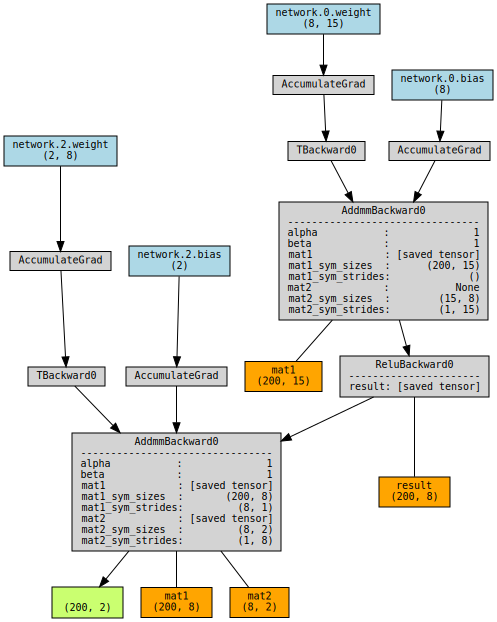

In [6]:

                        #           {
                        #     "experiment_number" : 2,
                        #    "window_size" : 5,
                        #    "h_size" : 8,
                        #    "l_num" : 1,
                        #    "epochs" : 500,
                        #    "learning_rate" : 0.001,
                        #    "part_of_data" : 100, 
                        #    "weight_decay" : 1e-5,
                        #    "percentage_of_data" : 0.8,
                        #    "batch_size" : 200,
                        #    "cut_off_timesteps" : 0,
                        #    "drop_half_timesteps": True,
                        #    "act_fn" : "relu",
                        #    "nonlin_at_out" : None #None if no nonlinearity at the end
                        # }

import torch
from torchviz import make_dot
from IPython.display import Image

x = next(iter(train_loader))[0]
y = model(x)
print(input_data2[0:1].size())
dot = make_dot(y, params=dict(model.named_parameters()),  show_attrs=True, show_saved=True)   # .render("model_graph", format="png")

#print(list(model.parameters()))

#calc 
erg=0
for a in list(model.parameters()):
    x = 1 
    for y in list(a.size()):
        x = x*y
    erg += x

print("anzahl der variablen" , erg)
# Remove autograd related nodes
#dot.attr(rankdir='LR')
dot.node_attr.update(style='filled')

# for node in dot.body:
#     if 'Backward' in node:
#         dot.body.remove(node)


dot
# Save the graph to a file
# dot.format = 'png'
# dot.render('model_graph')

# Display the graph in the Jupyter notebook
#Image(filename='model_graph.png')